<h1>Predictive maintenance for milling machines</h1> 
Kaggle dataset: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020 </br>
Analysis inspired by: https://www.kaggle.com/code/zakikurdya/predictive-maintenance </br>
Goal: Predict machine failures of milling machines based on the dataset

The dataset is part of a publication from: </br>
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.


<h2>Data Preparation</h2>

In [117]:
import pandas as pd

# Load the dataset
df = pd.read_csv('ai4i2020.csv')

# Display general dataset information, initial rows, and descriptive statistics
print("Dataset Information:\n")
df.info()

print("\nFirst 5 Rows of the Dataset:\n", df.head())

print("\nDescriptive Statistics:\n", df.describe())

# Check for missing values and unique value distributions in key columns
print("\nMissing Values by Column:\n", df.isnull().sum())

print("\n'Product Type' Distribution:\n", df['Type'].value_counts())

print("\n'Machine Failure' Distribution:\n", df['Machine failure'].value_counts())


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes

--> No null values, but unnecessary columns Product ID and UDI for our use case

In [118]:
# Drop unnecessary columns
df.drop(['Product ID', 'UDI'], axis=1, inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


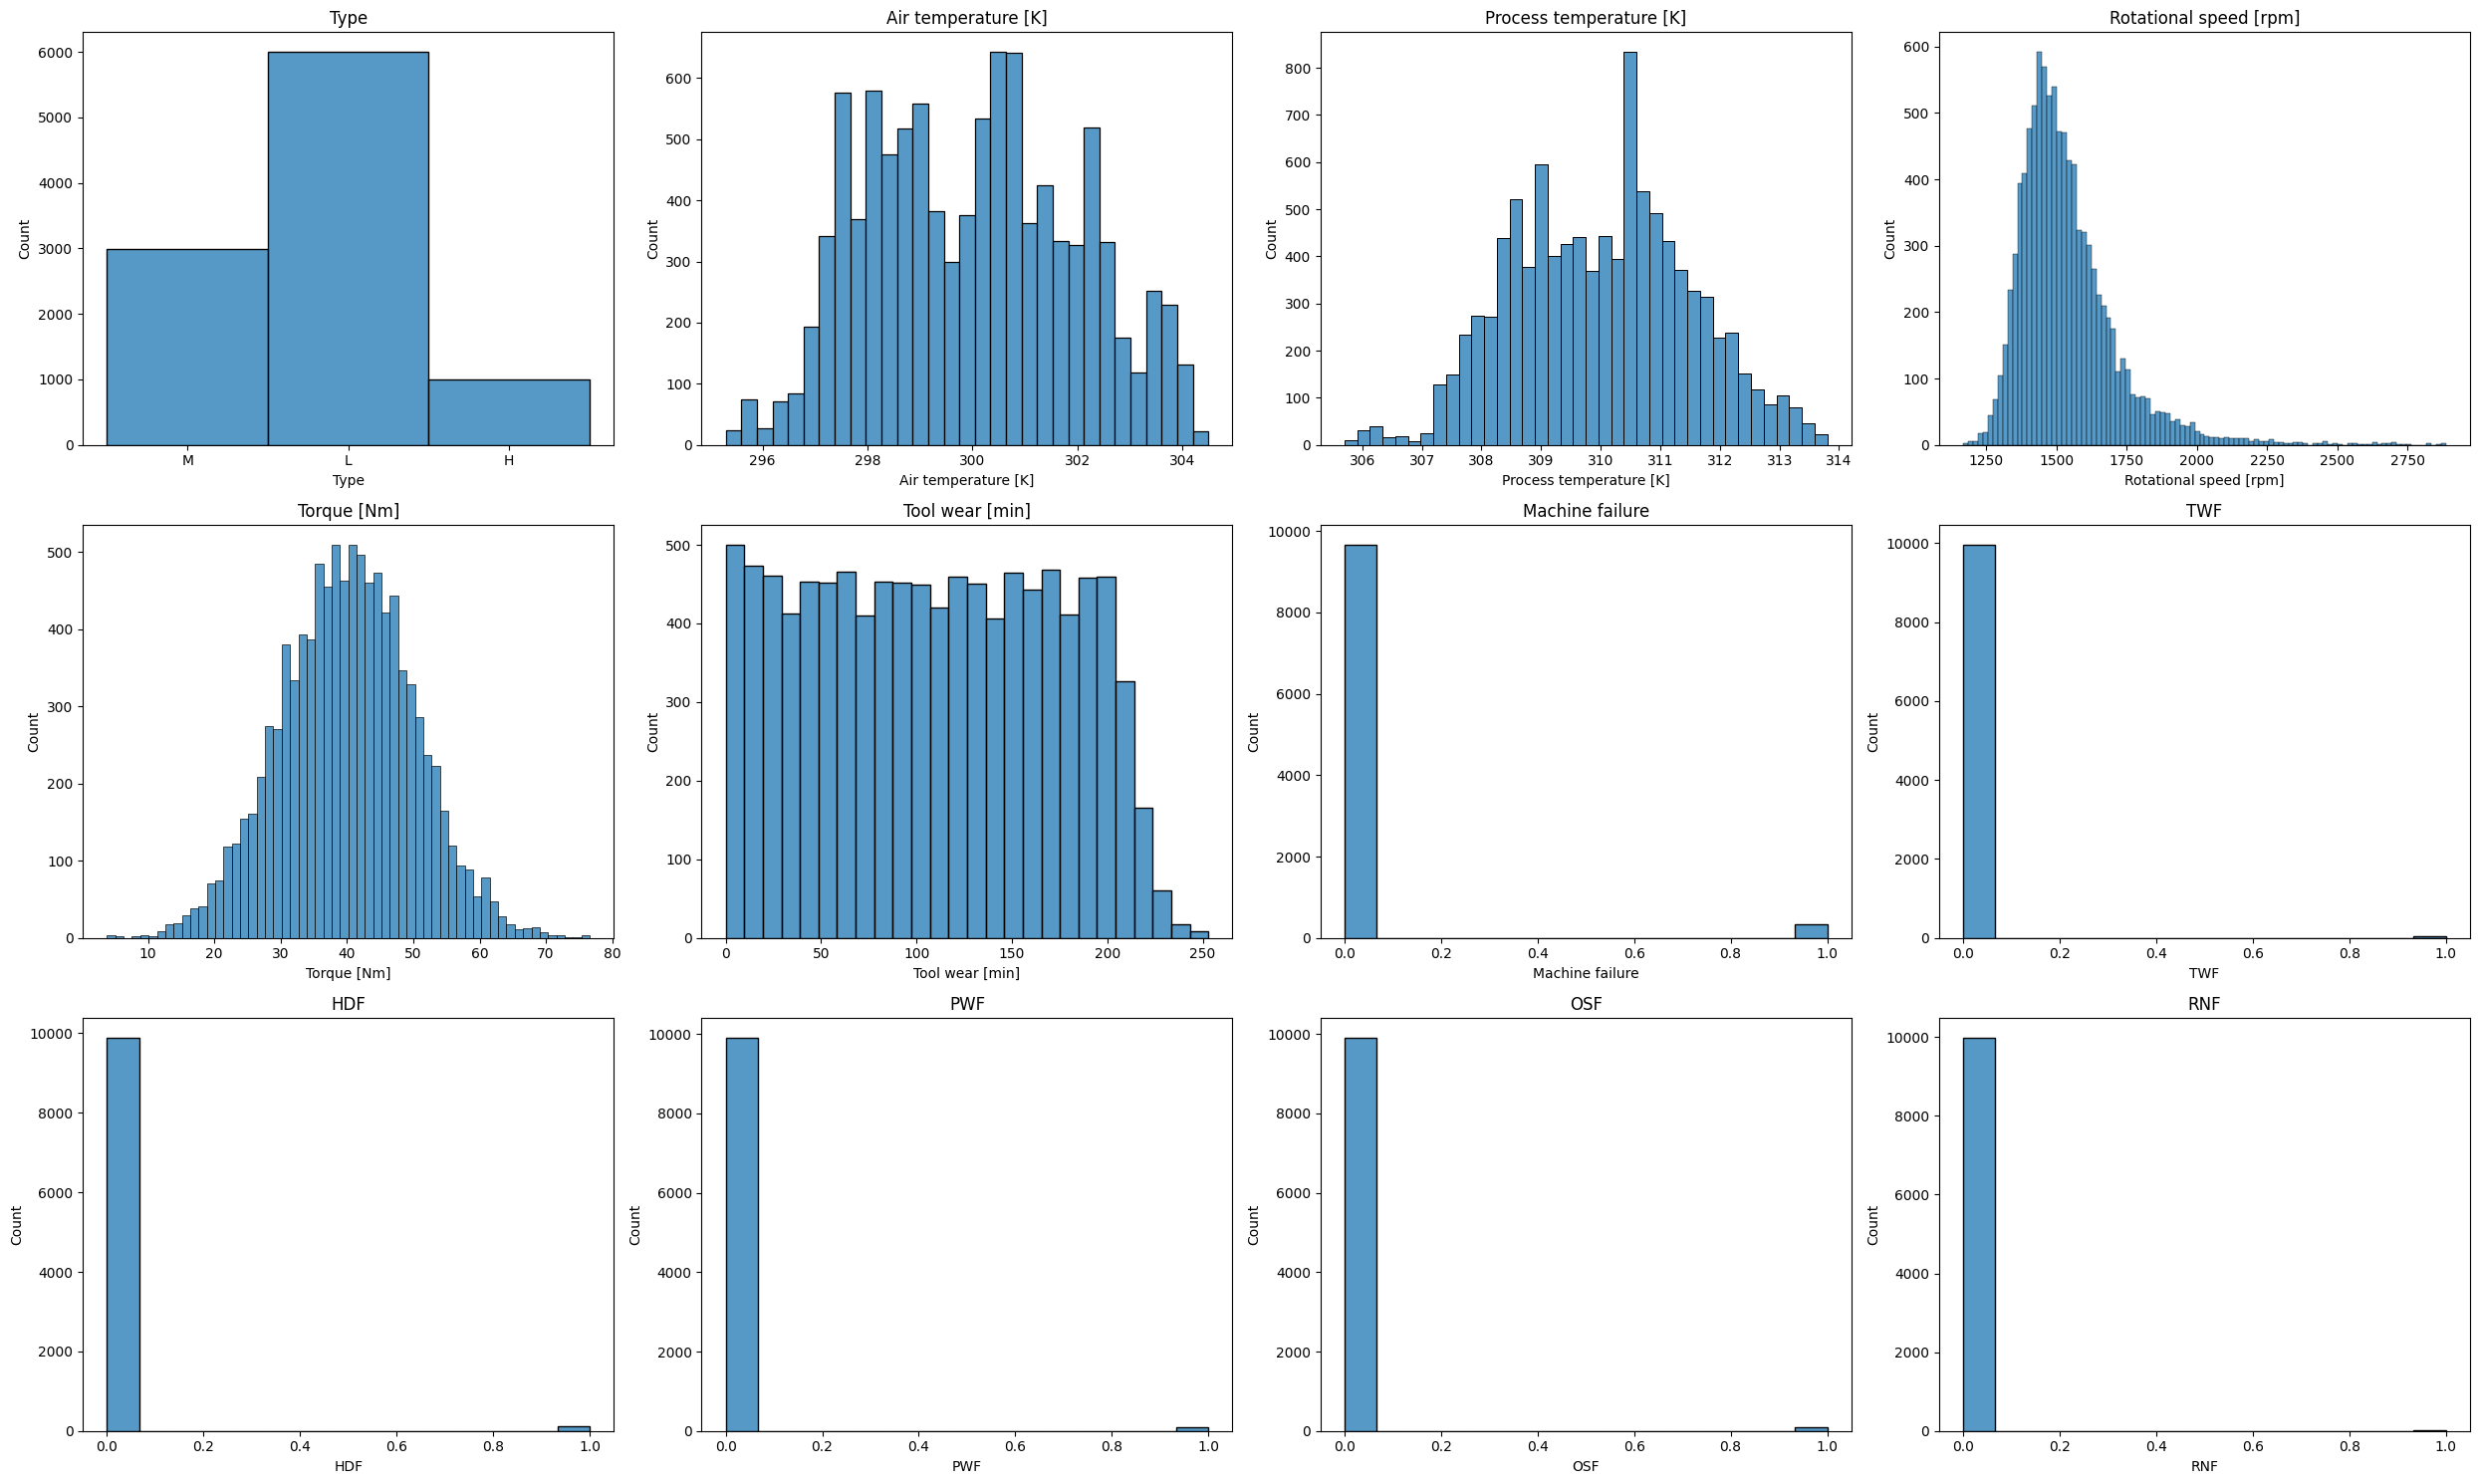

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Determine grid layout based on the number of columns
num_cols = len(df.columns)
n_cols = min(4, num_cols)
n_rows = -(-num_cols // n_cols)  # Equivalent to math.ceil(num_cols / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

# Plot each column in a separate subplot
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i])
    axes[i].set_title(col)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


--> The data is clearly imbalanced, which is something we need to solve for our ML algorithms

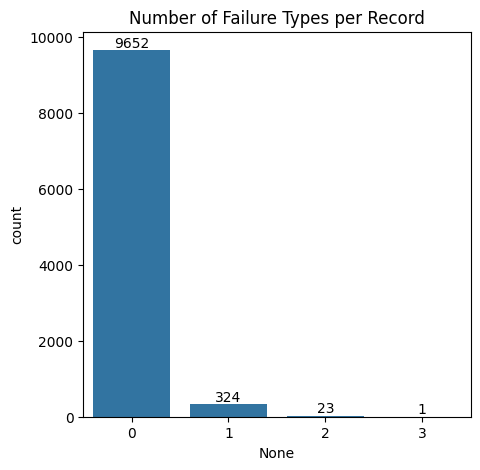

In [120]:
# Select failure type columns and calculate the sum of failure types per record
df_failures = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]
failure_count_per_record = df_failures.sum(axis=1)

# Plot the distribution of failure type counts per record
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=failure_count_per_record, ax=ax)

# Annotate each bar with its height
for patch in ax.patches:
    ax.annotate(f'{int(patch.get_height())}', 
                (patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                ha='center', va='bottom')

ax.set_title('Number of Failure Types per Record')
plt.show()


--> Number of failures is very low, so we should sum up all individual failure codes such as TWF, HDF, etc. as a machine failure

In [121]:
# Create 'Machine failure' column by checking if any failure type is present
df['Machine failure'] = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].any(axis=1).astype(int)

# Drop individual failure type columns
df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)


Replace the Types M, L, H with numerical values:

In [122]:
# Convert 'Type' attribute to numerical values and avoid inplace modification
df['Type'] = df['Type'].replace({'L': 0, 'M': 1, 'H': 2})


C:\Users\BOI2LE\AppData\Local\Temp\ipykernel_22364\558947661.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Type'] = df['Type'].replace({'L': 0, 'M': 1, 'H': 2})


Turning all values into floats

In [123]:
# Convert all columns to float data type
df = df.astype(float)

df.dtypes

Type                       float64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
Machine failure            float64
dtype: object

<h2>Modeling</h2>

Let's create train, test and validation datasets; including overfitting

In [124]:
from sklearn.model_selection import train_test_split

# First split: Train and Temp (for validation and test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Machine failure'], random_state=42)

# Second split: Validation and Test
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Machine failure'], random_state=42)

# Save the datasets as CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
validation_df.to_csv('validation.csv', index=False)


In [125]:
# Function to print failure statistics
def print_failure_stats(df, name):
    total = df.shape[0]
    failures = df['Machine failure'].sum()
    non_failures = total - failures
    print(f"{name} - Non-Failures: {non_failures}, Failures: {failures}, "
          f"Percentage of Failures: {failures / total * 100:.2f}%")

# Print statistics for each dataset
print_failure_stats(train_df, "Training Set")
print_failure_stats(test_df, "Test Set")
print_failure_stats(validation_df, "Validation Set")


Training Set - Non-Failures: 6756.0, Failures: 244.0, Percentage of Failures: 3.49%
Test Set - Non-Failures: 1448.0, Failures: 52.0, Percentage of Failures: 3.47%
Validation Set - Non-Failures: 1448.0, Failures: 52.0, Percentage of Failures: 3.47%


--> This consistency helps ensure that your model will train and evaluate appropriately without being biased by the imbalance in the dataset

Let's go ahead:
I chose these three methods because they are relatively simple to implement, offer clear interpretability, and effectively handle the type of binary classification problem we're dealing with in predicting machine maintenance needs. While other techniques exist, these two methods are well-suited for our dataset and provide valuable insights without unnecessary complexity.

1. Logistic Regression: This method is straightforward, providing a probabilistic model to predict whether machine failure will occur based on features like temperature and torque.

2. Decision Trees: Utilizing a tree-like structure, this method helps in making clear, rule-based decisions about machine failure by splitting the data based on feature thresholds.

3. Random Forest: This ensemble method combines multiple decision trees to improve prediction accuracy and robustness, making it effective in handling the complexities of maintenance predictions.


<h3> Logistic regression </h3>


In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Separate features and target variable from the training set
X_train = train_df.drop('Machine failure', axis=1)
y_train = train_df['Machine failure']

# Separate features and target variable from the validation set
X_validation = validation_df.drop('Machine failure', axis=1)
y_validation = validation_df['Machine failure']

# Initialize the Logistic Regression model
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = lr_model.predict(X_validation)

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_lr)
report = classification_report(y_validation, y_pred_lr)

print(f"Validation Set Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Validation Set Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.86      1448
         1.0       0.02      0.12      0.03        52

    accuracy                           0.76      1500
   macro avg       0.49      0.45      0.45      1500
weighted avg       0.93      0.76      0.83      1500



<h3>Decision Tree</h3>

In [127]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_dt = dt_model.predict(X_validation)

# Evaluate the model
accuracy_dt = accuracy_score(y_validation, y_pred_dt)
report_dt = classification_report(y_validation, y_pred_dt)

print(f"Validation Set Accuracy (Decision Tree): {accuracy_dt:.2f}")
print("Classification Report (Decision Tree):\n", report_dt)


Validation Set Accuracy (Decision Tree): 0.98
Classification Report (Decision Tree):
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1448
         1.0       0.66      0.63      0.65        52

    accuracy                           0.98      1500
   macro avg       0.82      0.81      0.82      1500
weighted avg       0.98      0.98      0.98      1500



Not necesary, but nice to see: We can visualize the Decision Tree as well

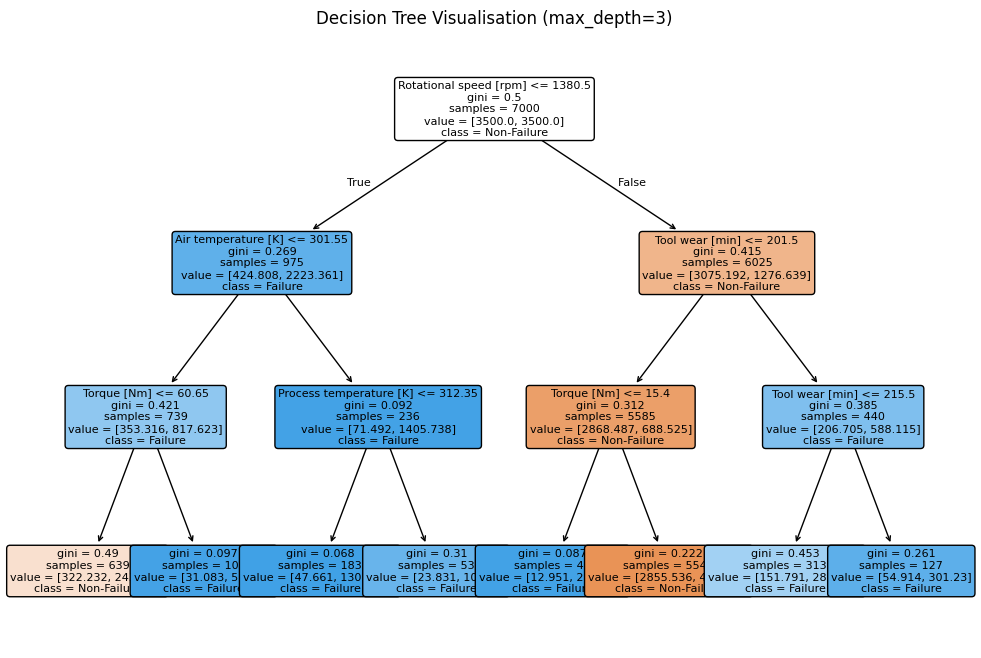

In [128]:
from sklearn.tree import plot_tree

# Set a maximum depth for the tree to avoid overfitting
dt_model = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Non-Failure', 'Failure'], rounded=True, fontsize=8)
plt.title('Decision Tree Visualisation (max_depth=3)')
plt.show()


<h3>Random Forest</h3>

Validation Set Accuracy (Random Forest): 0.98
Classification Report (Random Forest):
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1448
         1.0       0.90      0.54      0.67        52

    accuracy                           0.98      1500
   macro avg       0.94      0.77      0.83      1500
weighted avg       0.98      0.98      0.98      1500



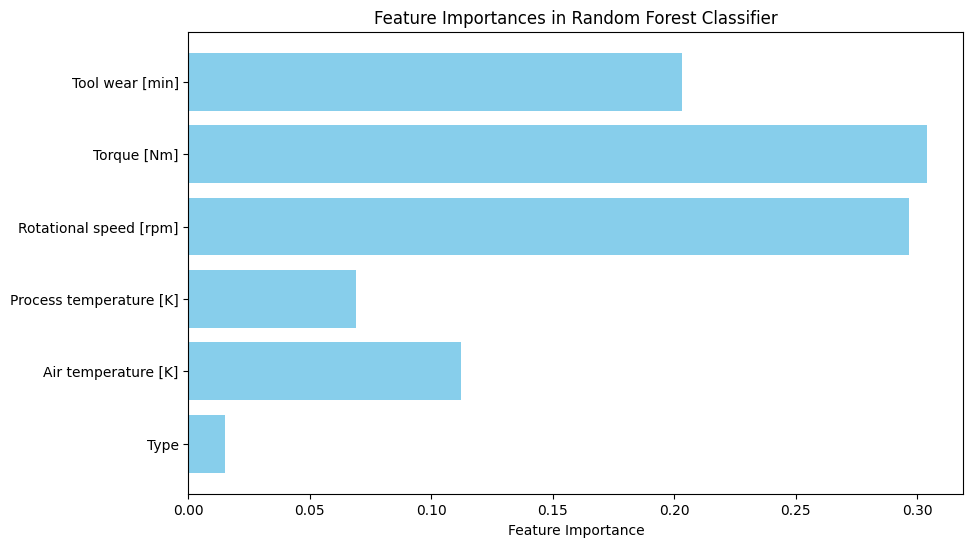

In [129]:
from sklearn.ensemble import RandomForestClassifier
importances = []
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_validation)

# Evaluate the model
accuracy_rf = accuracy_score(y_validation, y_pred_rf)
report_rf = classification_report(y_validation, y_pred_rf)

print(f"Validation Set Accuracy (Random Forest): {accuracy_rf:.2f}")
print("Classification Report (Random Forest):\n", report_rf)

# Get feature importances
importances = rf_model.feature_importances_

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest Classifier')
plt.show()


<h2>Comparison of ML models</h2>

We used the train and validation datasets so far; Now let's compare all model performances on the test dataset.

In [130]:
# Predictions on the test dataset
y_pred_lr = lr_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

# Evaluate Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

# Print results
print(f"Logistic Regression - Test Set Accuracy: {accuracy_lr:.2f}")
print("Logistic Regression Classification Report:\n", report_lr)

print(f"Decision Tree - Test Set Accuracy: {accuracy_dt:.2f}")
print("Decision Tree Classification Report:\n", report_dt)

print(f"Random Forest - Test Set Accuracy: {accuracy_rf:.2f}")
print("Random Forest Classification Report:\n", report_rf)


Logistic Regression - Test Set Accuracy: 0.81
Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.81      0.89      1448
         1.0       0.14      0.88      0.25        52

    accuracy                           0.81      1500
   macro avg       0.57      0.85      0.57      1500
weighted avg       0.97      0.81      0.87      1500

Decision Tree - Test Set Accuracy: 0.91
Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      1448
         1.0       0.25      0.81      0.38        52

    accuracy                           0.91      1500
   macro avg       0.62      0.86      0.66      1500
weighted avg       0.97      0.91      0.93      1500

Random Forest - Test Set Accuracy: 0.97
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99  

Overall accuracy is 81%, 91% and 97%. But for the case of predictive maintenance, the most important KPI is the % of failures correctly predicted. Let's see which model performs best here.

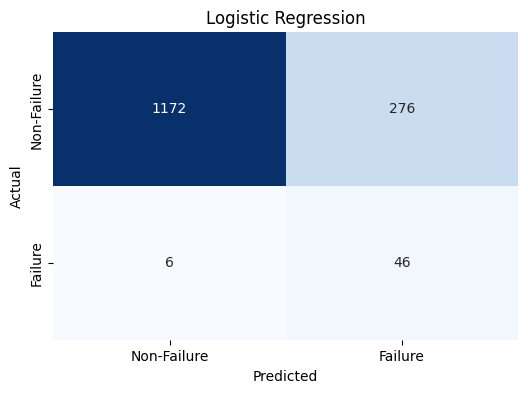

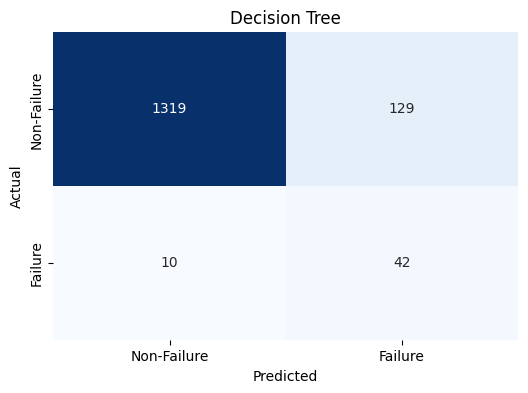

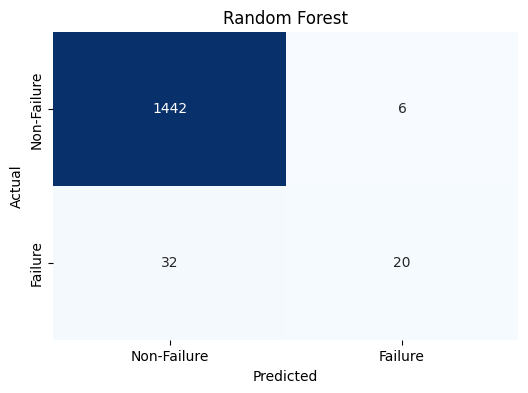

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd

# Predictions on the test dataset
y_preds = {
    'Logistic Regression': lr_model.predict(X_test),
    'Decision Tree': dt_model.predict(X_test),
    'Random Forest': rf_model.predict(X_test)
}

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics).T

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Failure', 'Failure'], yticklabels=['Non-Failure', 'Failure'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for model_name, y_pred in y_preds.items():
    plot_confusion_matrix(y_test, y_pred, model_name)


In [133]:
# Import necessary library
from sklearn.metrics import confusion_matrix

# Get confusion matrices for each model
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Extract True Positives (TP) and Total Actual Failures
TP_lr = cm_lr[1, 1]  # True Positives for Logistic Regression
TP_dt = cm_dt[1, 1]  # True Positives for Decision Tree
TP_rf = cm_rf[1, 1]  # True Positives for Random Forest

total_failures = sum(cm_lr[1])  # Total actual failures (same for all models)

# Calculate the KPI
kpi_lr = (TP_lr / total_failures) * 100 if total_failures > 0 else 0
kpi_dt = (TP_dt / total_failures) * 100 if total_failures > 0 else 0
kpi_rf = (TP_rf / total_failures) * 100 if total_failures > 0 else 0

# Print the KPIs
print(f"% of Failures Correctly Predicted (Logistic Regression): {kpi_lr:.2f}%")
print(f"% of Failures Correctly Predicted (Decision Tree): {kpi_dt:.2f}%")
print(f"% of Failures Correctly Predicted (Random Forest): {kpi_rf:.2f}%")


% of Failures Correctly Predicted (Logistic Regression): 88.46%
% of Failures Correctly Predicted (Decision Tree): 80.77%
% of Failures Correctly Predicted (Random Forest): 38.46%


--> The Random Forest model has a great accuracy of 97%, but it's largely ineffective for our use case since it fails to predict the actual failures accurately, showing a concerning 38.46% in correctly identifying them. In contrast, Logistic Regression and Decision Tree models deliver significantly better performance in predicting failures, with Logistic Regression achieving an impressive 88.46%. Even after balancing the dataset, Random Forest struggled to predict failures well, ending up worse than Logistic Regression.